In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
from sklearn.tree import plot_tree
import os
%matplotlib inline
sns.set_theme()
df = pd.read_csv('titanic-passengers.csv', sep=';')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,343,No,2,"Collander, Mr. Erik Gustaf",male,28.0,0,0,248740,13.0000,NaN,S
1,76,No,3,"Moen, Mr. Sigurd Hansen",male,25.0,0,0,348123,7.6500,F G73,S
2,641,No,3,"Jensen, Mr. Hans Peder",male,20.0,0,0,350050,7.8542,NaN,S
3,568,No,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.0,0,4,349909,21.0750,NaN,S
4,672,No,1,"Davidson, Mr. Thornton",male,31.0,1,0,F.C. 12750,52.0000,B71,S


In [2]:
df.columns


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [3]:
del_cols = ['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [4]:
df  = df.drop(del_cols,1)


In [5]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch'], dtype='object')

In [6]:
df = df.fillna(df["Age"].mean())


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    object 
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 41.9+ KB


In [8]:
le = LabelEncoder()

In [9]:
df["Sex"] = le.fit_transform(df["Sex"])

In [10]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,No,2,1,28.0,0,0
1,No,3,1,25.0,0,0
2,No,3,1,20.0,0,0
3,No,3,0,29.0,0,4
4,No,1,1,31.0,1,0


In [11]:
cleanup_Survived = {"Survived":     {"No": 0, "Yes": 1}}

In [12]:
df = df.replace(cleanup_Survived)

In [13]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,2,1,28.0,0,0
1,0,3,1,25.0,0,0
2,0,3,1,20.0,0,0
3,0,3,0,29.0,0,4
4,0,1,1,31.0,1,0


In [14]:
df.shape


(891, 6)

In [15]:
df.columns = ['output', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch']

In [16]:
df.head()

,output,Pclass,Sex,Age,SibSp,Parch
0,0,2,1,28.0,0,0
1,0,3,1,25.0,0,0
2,0,3,1,20.0,0,0
3,0,3,0,29.0,0,4
4,0,1,1,31.0,1,0


In [17]:
def entropy(col):
    counts = np.unique(col,return_counts=True)
    ent = 0.0
    for ix in counts[1]:
        p = ix/col.shape[0]
        ent += (-1.0*p*np.log2(p))
    return ent

In [18]:
def divide_data(x_data,fkey,fval):
    x_right = pd.DataFrame([],columns=x_data.columns)
    x_left = pd.DataFrame([],columns=x_data.columns)
    for ix in range(x_data.shape[0]):
        val = x_data[fkey].loc[ix]
        if val >=fval:
            x_right = x_right.append(x_data.iloc[ix])
        else:
            x_left = x_left.append(x_data.iloc[ix])
    return x_right,x_left

In [19]:
def information_gain(x_data,fkey,fval):
    right,left = divide_data(x_data,fkey,fval)
    
    l = float(left.shape[0])/x_data.shape[0]
    r = float(right.shape[0])/x_data.shape[0]
    if left.shape[0] == 0 or right.shape[0] == 0:
        return -99999
    i_gain = entropy(x_data.output) - (l * entropy(left.output) + r*entropy(right.output))
    return i_gain

In [20]:
class DecisionTree:
    def __init__(self,depth=0,max_depth=5):
        self.left = None
        self.right = None
        self.fkey = None
        self.fval = None
        self.depth = depth
        self.max_depth = max_depth
        self.target = None
    def train(self,x_train):
        features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']
        info_gains = []
        for ix in features:
            i_gain = information_gain(x_train,ix,x_train[ix].mean())
            info_gains.append(i_gain)
        self.fkey = features[np.argmax(info_gains)]
        self.fval = x_train[self.fkey].mean()
        print("Splitting Tree",self.fkey)
        data_right,data_left = divide_data(x_train,self.fkey,self.fval)
        data_right = data_right.reset_index(drop=True)
        data_left = data_left.reset_index(drop=True)
        if data_left.shape[0] == 0 or data_right.shape[0] == 0:
            if x_train.output.mean() >= 0.5:
                self.target = "Positive"
            else:
                self.target = "Negative"
            return
        if self.depth >= self.max_depth:
            if x_train.output.mean() >= 0.5:
                self.target = "Positive"
            else:
                self.target = "Negative"
            return
        self.left = DecisionTree(self.depth+1,self.max_depth)
        self.left.train(data_left)
        self.right = DecisionTree(self.depth+1,self.max_depth)
        self.right.train(data_right)
        if x_train.output.mean() >= 0.5:
            self.target = "Positive"
        else:
            self.target = "Negative"
        return
    def predict(self,test):
        if test[self.fkey] > self.fval:
            if self.right is None:
                return self.target
            return self.right.predict(test)
        if test[self.fkey] < self.fval:
            if self.left is None:
                return self.target
            return self.left.predict(test)

In [21]:
split = int(0.7*df.shape[0])
train_data = df[:split]
test_data = df[split:]
test_data= test_data.reset_index(drop=True)

In [22]:
dt = DecisionTree()

In [23]:
dt.train(train_data)

Splitting Tree Sex
Splitting Tree Pclass
Splitting Tree Pclass
Splitting Tree Parch
Splitting Tree Age
Splitting Tree Age
Splitting Tree Age
Splitting Tree Age
Splitting Tree SibSp
Splitting Tree Age
Splitting Tree Parch
Splitting Tree Age
Splitting Tree Age
Splitting Tree Age
Splitting Tree Age
Splitting Tree Age
Splitting Tree Age
Splitting Tree SibSp
Splitting Tree Age
Splitting Tree Parch
Splitting Tree Age
Splitting Tree Age
Splitting Tree Age
Splitting Tree Parch
Splitting Tree Age
Splitting Tree Parch
Splitting Tree Parch
Splitting Tree Age
Splitting Tree Age
Splitting Tree Parch
Splitting Tree Age
Splitting Tree Age
Splitting Tree Pclass
Splitting Tree Parch
Splitting Tree Pclass
Splitting Tree SibSp
Splitting Tree Age
Splitting Tree Age
Splitting Tree Age
Splitting Tree SibSp
Splitting Tree Age
Splitting Tree Age
Splitting Tree Age
Splitting Tree Pclass
Splitting Tree Age
Splitting Tree Pclass
Splitting Tree SibSp
Splitting Tree Age
Splitting Tree Parch
Splitting Tree SibSp
Sp

In [24]:
y_pred = []
for ix in range(test_data.shape[0]):
    y_pred.append(dt.predict(test_data.loc[ix]))

In [25]:
y_pred[:10]

['Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative']

In [26]:
for i in range(len(y_pred)):
    if y_pred[i] == "Negative":
        y_pred[i] = 0
    else:
        y_pred[i] = 1

In [27]:
np.mean(y_pred == test_data['output'])

0.7910447761194029

In [28]:
dt.left.left.fkey

'Pclass'

In [29]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']

In [30]:
sk_tree = DecisionTreeClassifier()

In [31]:
sk_tree.fit(train_data[features],train_data["output"])

DecisionTreeClassifier()

In [32]:
sk_tree.predict(test_data[features])

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1], dtype=int64)

In [33]:
sk_tree.score(test_data[features],test_data["output"])

0.7686567164179104

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
rf = RandomForestClassifier(n_estimators=10,criterion="entropy",max_depth=5)

In [36]:
rf.fit(train_data[features],train_data["output"])

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=10)

In [37]:
rf.score(train_data[features],train_data["output"])

0.8491171749598716

In [38]:
rf.score(test_data[features],test_data["output"])

0.8134328358208955

In [39]:
cross_val_score(RandomForestClassifier(n_estimators=10,criterion="entropy",max_depth=5),df[features],df["output"],cv=5).mean()

0.819327098110602

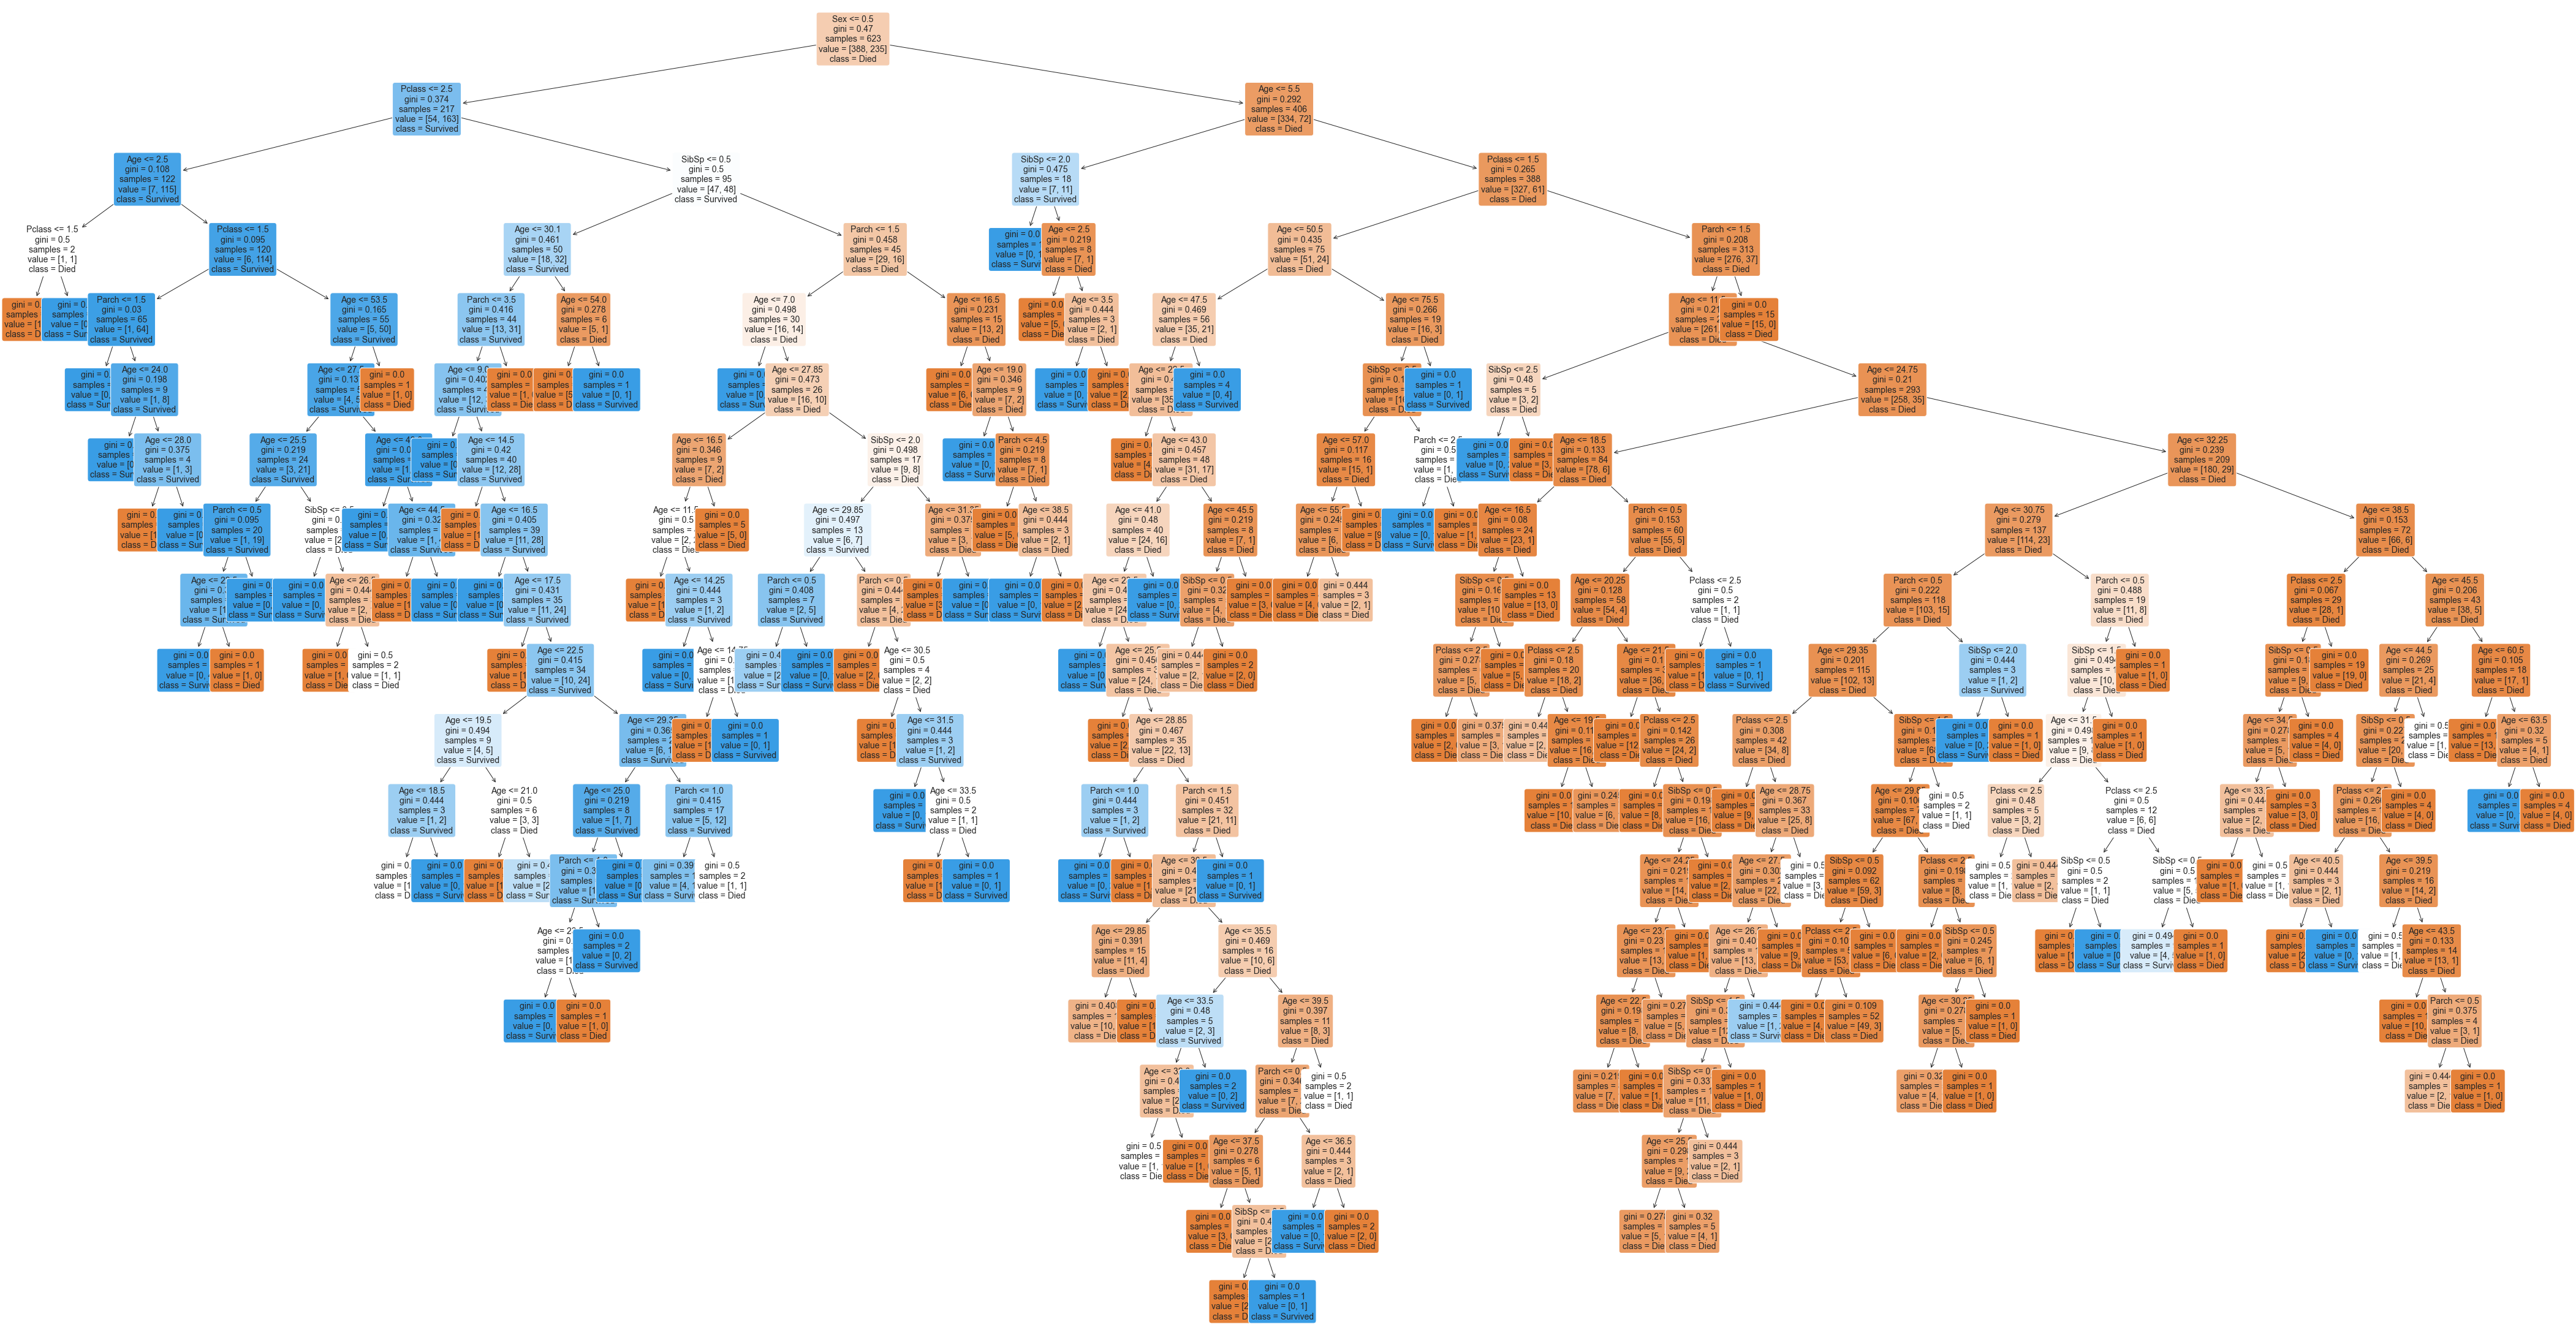

In [40]:
plt.figure(figsize=(75,40))
tree_1_image = plot_tree(sk_tree, 
              feature_names=df.iloc[:,1:].columns, 
              class_names={0:'Died',1:'Survived'},
              filled=True, 
              rounded=True, 
              fontsize=14)

In [66]:
print(train_data.shape)
print(test_data.shape)

(623, 6)
(268, 6)


In [73]:
import graphviz
from graphviz import Source
graph = Source( tree.export_graphviz(sk_tree, out_file=None,filled=True, 
                                rounded=True,  
                                special_characters=True, feature_names=train_data.columns))
graph.format = 'png'
graph.render('dtree_render',view=True)

ValueError: Length of feature_names, 6 does not match number of features, 5

In [43]:
from sklearn import tree
print(tree.export_text(sk_tree))

|--- feature_1 <= 0.50
|   |--- feature_0 <= 2.50
|   |   |--- feature_2 <= 2.50
|   |   |   |--- feature_0 <= 1.50
|   |   |   |   |--- class: 0
|   |   |   |--- feature_0 >  1.50
|   |   |   |   |--- class: 1
|   |   |--- feature_2 >  2.50
|   |   |   |--- feature_0 <= 1.50
|   |   |   |   |--- feature_4 <= 1.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_4 >  1.50
|   |   |   |   |   |--- feature_2 <= 24.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_2 >  24.00
|   |   |   |   |   |   |--- feature_2 <= 28.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_2 >  28.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |--- feature_0 >  1.50
|   |   |   |   |--- feature_2 <= 53.50
|   |   |   |   |   |--- feature_2 <= 27.50
|   |   |   |   |   |   |--- feature_2 <= 25.50
|   |   |   |   |   |   |   |--- feature_4 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_2 <= 22.50
|   |   |   |   |   |   |   |  

[Text(110.59263091216218, 211.7178947368421, 'X[1] <= 0.5\ngini = 0.47\nsamples = 623\nvalue = [388, 235]'),
 Text(54.951689189189196, 200.2736842105263, 'X[0] <= 2.5\ngini = 0.374\nsamples = 217\nvalue = [54, 163]'),
 Text(18.474324324324325, 188.82947368421054, 'X[2] <= 2.5\ngini = 0.108\nsamples = 122\nvalue = [7, 115]'),
 Text(6.032432432432433, 177.38526315789474, 'X[0] <= 1.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(3.0162162162162165, 165.94105263157894, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(9.04864864864865, 165.94105263157894, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(30.91621621621622, 177.38526315789474, 'X[0] <= 1.5\ngini = 0.095\nsamples = 120\nvalue = [6, 114]'),
 Text(15.081081081081082, 165.94105263157894, 'X[4] <= 1.5\ngini = 0.03\nsamples = 65\nvalue = [1, 64]'),
 Text(12.064864864864866, 154.49684210526317, 'gini = 0.0\nsamples = 56\nvalue = [0, 56]'),
 Text(18.0972972972973, 154.49684210526317, 'X[2] <= 24.0\ngini = 0.198\nsamples = 9\nv

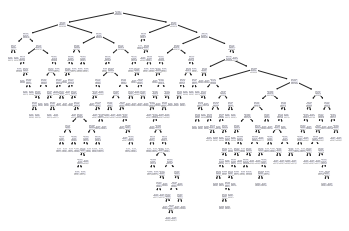

In [58]:
tree.plot_tree(sk_tree)